In [10]:

import matplotlib
%matplotlib notebook
matplotlib.use('nbagg')
import sys
import matplotlib.animation as anm
import matplotlib.pyplot as plt
import math
import matplotlib.patches as patches
import numpy as np
from enum import Enum


In [2]:
import sys                       
sys.path.append('../scripts/')
from scipy.stats import expon, norm, uniform
from enum import Enum
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RANSACRegressor
import numpy as np
from sklearn.metrics import r2_score

In [3]:
class Mode(Enum):
    STATE_TRANSITION = 1
    STRAIGHT_TRANSITION = 2
    SHIFT_TRANSITION = 3
    
class Switch(Enum):
    THROUGH = 1
    STRAIGHT = 2
    SHIFT = 3
    REGRESSION = 4

class World:
    def __init__(self, time_span, time_interval, debug=True):
        self.objects = []  
        self.debug = debug
        self.time_span = time_span  
        self.time_interval = time_interval 

        
    def append(self,obj):  
        self.objects.append(obj)
    
    def draw(self): 
        fig = plt.figure(figsize=(4,4))
        ax = fig.add_subplot(111)
        ax.set_aspect('equal')             
        ax.set_xlim(-300,300)                  
        ax.set_ylim(-300,300)
        #ax.set_xlim(-5,5)
        #ax.set_ylim(-5,5)
        ax.set_xlabel("Y",fontsize=10)                 
        ax.set_ylabel("X",fontsize=10)                 
        elems = []
        
        if self.debug:        
            for i in range(int(self.time_span/self.time_interval)): self.one_step(i, elems, ax)
        else:
            self.ani = anm.FuncAnimation(fig, self.one_step, fargs=(elems, ax),
                                     frames=int(self.time_span/self.time_interval+1), interval=int(self.time_interval*100), repeat=False)
            plt.show()
        
    def one_step(self, i, elems, ax):
        while elems: elems.pop().remove()
        time_str = "t = %.2f[s]" % (self.time_interval*i)
        elems.append(ax.text(-245.4, 220, time_str, fontsize=10))
        #elems.append(ax.text(-4.4, 4.5, time_str,fontsize=10))
        for obj in self.objects:
            obj.draw(ax, elems)
            if hasattr(obj, "one_step"): obj.one_step(self.time_interval)    

class rob:
    def __init__(self,pose,agent):
        self.pose = pose
        self.agent = agent
        
        self.obs_stuck = 0
        self.obs_sign = 0
        
        self.angle = 3
        
        self.a = 0
        self.b = 0
    
    def draw(self,ax, elems):
        pass
    
    def state_transition(self,nu,omega,time,pose):
        t0 = pose[2]
        if math.fabs(omega) < 1e-10:
            return pose + np.array( [nu*math.cos(t0), 
                                     nu*math.sin(t0),
                                     omega ] ) * time
        else:
            return pose + np.array( [nu/omega*(math.sin(t0 + omega*time) - math.sin(t0)), 
                                     nu/omega*(-math.cos(t0 + omega*time) + math.cos(t0)),
                                     omega*time ] )
    #agentXクラスのもとでつかうことを想定          
    def transition(self, nu,omega, time,obs):
        if self.agent.mode == Mode.STATE_TRANSITION:
            return self.state_transition(nu,omega,time,self.pose)
        elif self.agent.mode == Mode.STRAIGHT_TRANSITION:
            return self.straight_transition(nu,omega, time, obs)
        elif self.agent.mode == Mode.SHIFT_TRANSITION:
            return self.shift_transition(nu,omega,time, obs)
        else:
            return self.state_transition(nu,omega,time, self.pose)
        
    def sensor_return(self,obs):
        
        if obs:
            if len(obs) == 1:
                if np.abs(obs[0][0][1]) >= self.angle /180 * math.pi :
                    self.obs_stuck = np.abs(obs[0][0][1]) - self.angle / 180 * math.pi
                    self.obs_sign = np.sign(obs[0][0][1])
                    return  self.obs_sign * self.angle / 180 * math.pi
                else:
                    return obs[0][0][1]
            else:
    #             print("straight goal direction: ", obs[1][0])
                if np.abs(obs[1][0][1]) > self.angle /180 * math.pi :
                    self.obs_stuck = np.abs(obs[1][0][1]) - self.angle / 180 * math.pi
                    self.obs_sign = np.sign(obs[1][0][1])
                    return  self.obs_sign * self.angle / 180 * math.pi
                else:
                    return obs[1][0][1]

        if self.obs_stuck > self.angle / 180 * math.pi:
            self.obs_stuck = self.obs_stuck - self.angle / 180 * math.pi
            return self.obs_sign *  self.angle / 180 * math.pi
        else:
            self.a = self.obs_stuck
            self.b = self.obs_sign
            self.obs_stuck = 0
            self.obs_sign = 0
            return self.a *self.b / 180 * math.pi
        
   #agentXクラスのもとでつかうことを想定                         
    def straight_transition(self,nu,omega,time,obs):
        t0 = self.pose[2]        
        a = self.sensor_return(obs)
#         print(a)
        if math.fabs(omega) < 1e-10:
            return self.pose + np.array( [nu* math.cos(t0)*time, 
                             nu *math.sin(t0)*time,
                             omega*time  + a] )
        else:
            return self.pose + np.array( [nu  / omega*(math.sin(t0 + omega*time) - math.sin(t0)), 
                             nu  / omega*(-math.cos(t0 + omega*time) + math.cos(t0)),
                             omega*time + a ] )
        
    #agentXクラスのもとでつかうことを想定                      
    def shift_transition(self, nu, omega, time, obs):
        if obs[0] is not None and obs[0] != []:
            if obs[0][0][0][0] < self.agent.distance_minimum:
                self.agent.decelerate_nu
                self.agent.keep_shift_change()
            
        t0 = self.pose[2]
        
        if math.fabs(omega) < 1e-10:
            return self.pose + np.array( [nu *math.cos(t0)*time+2.0, 
                                 nu *math.sin(t0)*time,
                                 omega*time+self.sensor_return(obs) ] )/ math.sqrt((nu * self.accelerate_rate *math.cos(t0)*time+2.0)**2 +(nu * self.accelerate_rate *math.sin(t0)*time)**2) * math.sqrt((nu * self.accelerate_rate *math.cos(t0)*time)**2 +(nu * self.accelerate_rate *math.sin(t0)*time)**2) 
        else:
            return self.pose + np.array( [nu/omega*(math.sin(t0 + omega*time) - math.sin(t0))+2.0, 
                                 nu  /omega*(-math.cos(t0 + omega*time) + math.cos(t0)),
                                 omega*time+self.sensor_return(obs) ] )/ math.sqrt((nu/omega*(math.sin(t0 + omega*time) - math.sin(t0))+2.0)**2 + (nu* self.accelerate_rate/omega*(-math.cos(t0 + omega*time) + math.cos(t0))**2 )) * math.sqrt((nu* self.accelerate_rate/omega*(math.sin(t0 + omega*time) - math.sin(t0)))**2 + (nu* self.accelerate_rate/omega*(-math.cos(t0 + omega*time) + math.cos(t0))**2 ))

# In[3]:

class IdealRobot(rob):   
    def __init__(self, pose, agent=None, sensor=None, color="black"):    # 引数を追加
        super().__init__(pose,agent)
        self.pose = pose
        self.r = 10  
        self.color = color 
        self.agent = agent
        self.poses = [pose]
        self.id = 0
        self.sensor = sensor    # 追加
    
    def draw(self, ax, elems):         ### call_agent_draw
        x, y, theta = self.pose  
        xn = x + self.r * math.cos(theta)
        yn = y + self.r * math.sin(theta)
        elems += ax.plot([y,yn], [x,xn], color=self.color)
        c = patches.Circle(xy=(y, x), radius=self.r, fill=False, color=self.color) 
        elems.append(ax.add_patch(c))
        self.poses.append(self.pose)
        elems.append(ax.text(self.pose[1]-20, self.pose[0]-20, "child AUV", fontsize=8))         
        elems += ax.plot([e[1] for e in self.poses], [e[0] for e in self.poses], linewidth=0.5, color="black")
        if self.sensor and len(self.poses) > 1:
            self.sensor.draw(ax, elems, self.poses[-2])
        if self.agent and hasattr(self.agent, "draw"):                               #以下2行追加   
            self.agent.draw(ax, elems)

    def one_step(self, time_interval):
        if not self.agent: return        
        obs =self.sensor.data(self.pose) if self.sensor else None #追加
        nu, omega = self.agent.decision(obs) #引数追加
        self.pose = self.state_transition(nu, omega, time_interval, self.pose)
        if self.sensor: self.sensor.data(self.pose)   
            
# In[4]:


class Agent: 
    def __init__(self, nu, omega):
        self.nu = nu
        self.omega = omega
        self.mode = Mode.STATE_TRANSITION
        
    def decision(self, observation=None):
        return self.nu, self.omega

class AgentX:
    def __init__(self,time_interval, nu, omega, switch,accelerate_rate, distance_mintomax, regr_r_slope):
        self.nu = nu
        self.omega = omega
        
        self.const_nu = nu
        
        self.mode = Mode.STATE_TRANSITION
        
        self.accelerate_rate = accelerate_rate

        self.switch = switch
#         self.ligression_switch = ligression_switch

        self.keep_regression = False
        self.keep_straight = False
        self.keep_shift = False
        
        self.distance_maximum = distance_mintomax[1]
        self.distance_minimum = distance_mintomax[0]
        self.count = 0
        
        self.r_minimum = regr_r_slope[0]
        self.slope_maximum = regr_r_slope[1]
        
        self.sensor_num = 0
        self.sensor_stuck = []
        self.sensor_stuck_train = []
        
        self.time_interval = time_interval
        
        self.t_train = []
        
        if(self.distance_minimum > self.distance_maximum):
            print("input error")
            sys.exit()
            
        
    def decision(self, observation=None):

        if observation:
            self.mode = self.mode_change(observation)
#         print(self.count)
#         print(self.time_interval)
        self.count = self.count + self.time_interval
        return self.nu, self.omega
    
#     def shift_switch_change(self):
#         self.shift_switch = not self.shift_switch
    
    def keep_straight_change(self):
        self.keep_straight = not self.keep_straight
    
    def keep_shift_change(self):
        self.keep_shift = not self.keep_shift
        
    def keep_regression_change(self):
        self.keep_regression = not self.keep_regression
        
    def accelerate_nu(self):
        self.nu = self.const_nu * self.accelerate_rate
    
    def decelerate_nu(self):
        self.nu = self.const_nu
        
    def mode_change(self,obs):
        
        r = 0
        slope = [0]
        distance = 0
#         print(self.accelerate_switch)
        
        if (self.switch == Switch.REGRESSION):
            r,slope, distance = self.regression(obs)

        if ((obs[0][0][0] > self.distance_maximum) and(self.switch == Switch.STRAIGHT)) or (self.keep_straight == True) :
#             print("GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG!!!!!!!!!!!!!!!!!!!")
#             print("straight:",self.keep_straight)
            if (self.keep_straight == False) :
                self.accelerate_nu()
                self.keep_straight_change()
            if obs is not None and obs != []: 
                if obs[0][0][0] < self.distance_minimum:
                    self.decelerate_nu()
                    self.keep_straight_change()                                        
#             self.nu = self.const_nu * self.accelerate_rate * math.cos(obs[0][0][1])
            return Mode.STRAIGHT_TRANSITION

        elif ((obs[0][0][0] > self.distance_maximum) and (self.switch == Switch.SHIFT)) or (self.keep_shift == True):
            print("aasdf;lkjasdf;lkjasdf;lkajsd;lkj;")      
            if (self.keep_shift == False):
                self.accelerate_nu()
                self.keep_shift_change()
            return Mode.SHIFT_TRANSITION
        elif ((distance > self.distance_maximum) and (self.switch == Switch.REGRESSION)) or (self.keep_regression == True):
#         elif(((r < self.r_minimum) and (slope[0] > self.slope_maximum)) and (self.switch == Switch.REGRESSION)) or (self.keep_regression == True) or ((obs[0][0][0] > self.distance_maximum * 1.05) and (self.switch == Switch.REGRESSION))  :
#             print(" keep accelerate!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!", self.keep_accelerate)
            if(self.keep_regression == False):
                self.accelerate_nu()
                self.keep_regression_change()
#             if (self.r_minimum <= r) and (slope[0] <= self.slope_maximum):
#                 self.decelerate_nu()
#                 self.keep_regression_change()
#                 print("nu: ",self.nu)        
            if obs is not None and obs != []: 
                if obs[0][0][0] < self.distance_minimum:
                    self.decelerate_nu()
                    self.keep_regression_change()  
            print("nu: ",self.nu)   
            return Mode.STRAIGHT_TRANSITION
        
        else:
#             print('aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa!')
            return Mode.STATE_TRANSITION
        
    def regression(self,obs):
        train_length = 50
        test_length = 3
        
#すたっくの値と一致するときだけ追加する　ラスト　-1でかける　差が1e-5未満のとき　みたいなやり方をした
        if obs[0] is not None :
            if len(self.sensor_stuck)  > 1 and abs(self.sensor_stuck[-1] - obs[0][0][0])  < 1e-5 :
                return 1,[0],0
            value = obs[0][0][0]
            if self.sensor_num < train_length:
                self.sensor_stuck.append(value)
                self.sensor_stuck_train.append(value)
                self.t_train.append(self.count)
                self.sensor_num = self.sensor_num + 1
                
            else:
                self.sensor_stuck.append(value)
                self.sensor_stuck_train.pop(0)
                self.sensor_stuck_train.append(value)

                self.t_train.pop(0)
                self.t_train.append(self.count)
                self.sensor_num = self.sensor_num + 1
                
        if (obs[0] is not None) and (len(self.sensor_stuck_train) > 10)  and (len(self.t_train) > 10 ) :
            X = np.array(self.t_train).reshape(-1, 1)
            y = np.array(self.sensor_stuck_train).reshape(-1, 1)
            
#             print(self.sensor_stuck_train)
#             print(self.t_train)

            lr = LinearRegression()
            lr.fit(X, y)
            y_train_pred = lr.predict(X)
            
            r = r2_score(y, y_train_pred)
            slope = lr.coef_[0]
            return_value = []
            
            if r  > 0.3:
                t_array = []
                return_t_value = self.t_train[-1]  + r * 100
                t_array.append(return_t_value)
                return_t = np.array(t_array).reshape(-1,1)
                return_value = lr.predict(return_t)

            else:
                return_value.append(obs[0][0][0])


            return r2_score(y, y_train_pred), lr.coef_[0], return_value[0]
        
        else :
            return 1,[0],0

        
class AgentY:
    def __init__(self,time_interval, data):
        self.nu = 0
        self.omega = 0
        self.time_interval = time_interval
        self.data = data
        self.iterator = iter(self.data)
        self.current_data = []
        self.time = 0
        self.mode = Mode.STATE_TRANSITION
        
    def decision(self, observation=None):
        self.data_change()
        return self.nu, self.omega
        
    def data_change(self):
        if(self.time <= 1e-10):
            print("chaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaange!")
            self.current_data = next(self.iterator, "end")
            if(self.current_data == "end"):
#                 print("byebye")
                return
#             print(self.current_data)
            self.nu = self.current_data[0]
            self.omega = self.current_data[1]
            self.time = self.current_data[2]
        self.time = self.time - self.time_interval
#        print(self.time)
            
# In[5]:


class Landmark:
    def __init__(self, pos , agent = None):
        self.pos = pos
        self.agent = agent
        self.id = None
        
    def draw(self, ax, elems):
        c = ax.scatter(self.pos[1], self.pos[0], s=30, marker="*", label="landmarks", color="orange")
        elems.append(c)
#         elems.append(ax.text(self.pos[0], self.pos[1], "id:" + str(self.id), fontsize=10))
        elems.append(ax.text(self.pos[1]-20, self.pos[0]-20, "parent AUV", fontsize=8))
    def state_transition(cls, nu, omega, time, pose):
        t0 = pose[2]
        if math.fabs(omega) < 1e-10:
            return pose + np.array( [nu*math.cos(t0), 
                                     nu*math.sin(t0),
                                     omega ] ) * time
        else:
            return pose + np.array( [nu/omega*(math.sin(t0 + omega*time) - math.sin(t0)), 
                                     nu/omega*(-math.cos(t0 + omega*time) + math.cos(t0)),
                                     omega*time ] )

    def one_step(self, time_interval):
        if not self.agent: return        
        nu, omega = self.agent.decision() #引数追加
        self.pos = self.state_transition(nu, omega, time_interval, self.pos) 


# In[6]:


class Map:
    def __init__(self):       # 空のランドマークのリストを準備
        self.objects = []
        
    def append_object(self, ob):       # ランドマークを追加
        ob.id = len(self.objects)           # 追加するランドマークにIDを与える
        self.objects.append(ob)

    def draw(self, ax, elems):                 # 描画（Landmarkのdrawを順に呼び出し）
        for ob in self.objects: ob.draw(ax, elems)

    def one_step(self,time_interval):
        for ob in self.objects: ob.one_step(time_interval)
                         


# In[7]:


class IdealCamera:
    def __init__(self, env_map, distance_range=(0.5, 350), direction_range=(-math.pi, math.pi)):
        self.map = env_map
        self.lastdata = []
        
        self.distance_range = distance_range
        self.direction_range = direction_range
        
    def visible(self, polarpos):  # ランドマークが計測できる条件
        if polarpos is None:
            return False
        #print(polarpos[0])
        #print(self.distance_range[0])
        #print(self.distance_range[1])
        #print(self.distance_range[0] <= polarpos[0] and polarpos[0] <= self.distance_range[1])
    
        return self.distance_range[0] <= polarpos[0] <= self.distance_range[1]                 and self.direction_range[0] <= polarpos[1] <= self.direction_range[1]
        
    def data(self, cam_pose):
        observed = []
        for lm in self.map.objects:
            z = self.observation_function(cam_pose, lm.pos)
            if self.visible(z):               # 条件を追加
                observed.append((z, lm.id))   # インデント
            
        self.lastdata = observed
        return observed
    
    @classmethod
    def observation_function(cls, cam_pose, obj_pos):
        #print("obj=",obj_pos)
        #print("cam=",cam_pose)
        diff = obj_pos[0:2]- cam_pose[0:2]
        phi = math.atan2(diff[1], diff[0]) - cam_pose[2]
        while phi >= np.pi: phi -= 2*np.pi
        while phi < -np.pi: phi += 2*np.pi
        return np.array( [np.hypot(*diff), phi ] ).T
    
    def draw(self, ax, elems, cam_pose): 
        for lm in self.lastdata:
            x, y, theta = cam_pose
            distance, direction = lm[0][0], lm[0][1]
            lx = x + distance * math.cos(direction + theta)
            ly = y + distance * math.sin(direction + theta)
            elems += ax.plot([y,ly], [x,lx], color="pink")


In [4]:

# In[2]:


class Robot(IdealRobot):
        
    def __init__(self, pose, agent=None, sensor=None, color="black",                            noise_per_meter=2, noise_std=math.pi/180, bias_rate_stds=(0.03,0.03),                            expected_stuck_time=1e100, expected_escape_time = 1e-100,                           expected_kidnap_time=1e100, kidnap_range_x = (-5.0,5.0), kidnap_range_y = (-5.0,5.0)): #追加
        super().__init__(pose, agent, sensor, color)
        #noise に必要な変数
        #大域でグラフを生成しないと関数の呼び出しごとに関数を生成することになる
        #出てくる値がランダムじゃなくなる
        self.noise_pdf = expon(scale=1.0/(1e-100 + noise_per_meter))
        self.distance_until_noise = self.noise_pdf.rvs()
        self.theta_noise = norm(scale=noise_std)
        self.nu_noise_rate = 0.03
        self.omega_noise_rate = math.pi / 180
        
        #biasに必要な関数
        self.bias_rate_nu = norm.rvs(loc=1.0, scale=bias_rate_stds[0])
        self.bias_rate_omega = norm.rvs(loc=1.0, scale=bias_rate_stds[1]) 

#         self.bias_rate_nu = 1.03
#         self.bias_rate_omega = 1.03
        
        #stuckに必要な関数
        self.stuck_pdf = expon(scale=expected_stuck_time) 
        self.escape_pdf = expon(scale=expected_escape_time)
        self.is_stuck = False
        self.time_until_stuck = self.stuck_pdf.rvs()
        self.time_until_escape = self.escape_pdf.rvs()
        
        #kidnapに必要な関数
        self.kidnap_pdf = expon(scale=expected_kidnap_time) 
        self.time_until_kidnap = self.kidnap_pdf.rvs()
        rx, ry = kidnap_range_x, kidnap_range_y
        self.kidnap_dist = uniform(loc=(rx[0], ry[0], 0.0), scale=(rx[1]-rx[0], ry[1]-ry[0], 2*math.pi ))
        
        #one_stepに必要な関数
        self.is_first = True
        
        self.const_time = 2.0
        self.sensor_time = self.const_time 
        
        self.sensor_stuck = []
        
        
#     def noise(self, pose, nu, omega, time_interval):
#         self.distance_until_noise -= abs(nu)*time_interval + self.r*abs(omega)*time_interval
#         if self.distance_until_noise <= 0.0:
#             self.distance_until_noise += self.noise_pdf.rvs()
#             pose[2] += self.theta_noise.rvs()
#         return pose
    def noise(self, nu, omega):
        nu_2 = norm.rvs(loc=nu, scale=nu *self.nu_noise_rate)
        omega_2 = norm.rvs(loc=omega, scale= self.omega_noise_rate)
        print("omega", omega_2)
        return nu_2, omega_2
    
    def bias(self, nu, omega): 
        return nu*self.bias_rate_nu, omega*self.bias_rate_omega
    
#     def sensor_append(self, mode, obs):
#         if mode == True:
#             if obs:
#                 self.sensor_stuck.append(obs)
    
    
    def sensor_count(self, time_interval):
#         print("sensor time", self.sensor_time)
        if(self.sensor_time > 0.15) and (self.is_first == False):
            self.sensor_time -= time_interval
            return None
        elif self.is_first == True:
            self.is_first = False
            return self.sensor.data(self.pose) if self.sensor else None
        else:
            self.sensor_time = self.const_time
            return self.sensor.data(self.pose) if self.sensor else None
        
    def one_step(self,time_interval):
        if not self.agent: return
        obs = self.sensor_count(time_interval)
            
#         self.sensor_append(True,obs)      
        nu, omega = self.agent.decision(obs)
        nu, omega = self.bias(nu, omega)
        nu, omega = self.noise(nu,omega)
        print("nu, omega",nu,omega)
#         print("robot deeeeeeeeeesu:", self.agent.mode)
#         print("robot obs:",obs)
        info = []
        if obs is not None:
            info.append(obs)
            info.append(self.sensor.angle(self.pose))  
            print("robot no obs deeeeeeeeeeeeeeeeesu:", info)

        
#             print("info: ",info)
        self.pose = self.transition(nu,omega,time_interval,info)

#         self.pose = self.noise(self.pose, nu,omega, time_interval)


# In[3]:


class Camera(IdealCamera): ###noisesim_occlusion### 
    def __init__(self, env_map,
                 distance_range=(0.5, 350),
                 direction_range=(-math.pi, math.pi),
                 distance_noise_rate=0.03, direction_noise_rate=math.pi / 180,
                 distance_bias_rate_stddev=0.03, direction_bias_stddev=math.pi / 180,
                 phantom_prob=0.0, phantom_range_x=(-5.0,5.0), phantom_range_y=(-5.0,5.0),
                 oversight_prob=0.1, occlusion_prob=0.0): #occlusion_prob追加
        super().__init__(env_map, distance_range, direction_range)
        
        self.distance_noise_rate = distance_noise_rate
        self.direction_noise_rate = direction_noise_rate  
        self.distance_bias_rate_std = norm.rvs(scale=distance_bias_rate_stddev)
        self.direction_bias = norm.rvs(scale=direction_bias_stddev) 
        
        rx, ry = phantom_range_x, phantom_range_y
        self.phantom_dist = uniform(loc=(rx[0], ry[0]), scale=(rx[1]-rx[0], ry[1]-ry[0]))
        self.phantom_prob = phantom_prob
        
        self.oversight_prob = oversight_prob
        self.occlusion_prob = occlusion_prob #追加
        
        self.landmark_to_goal = 30
        
    def noise(self, relpos):  
        ell = norm.rvs(loc=relpos[0], scale=relpos[0]*self.distance_noise_rate)
        phi = norm.rvs(loc=relpos[1], scale= self.direction_noise_rate)
        return np.array([ell, phi]).T
    
    def bias(self, relpos): 
        return relpos + np.array([relpos[0]*self.distance_bias_rate_std,
                                   self.direction_bias]).T
    
    def data(self, cam_pose):
        observed = []

        for lm in self.map.objects:
            #print("camera data obj=",lm.pos)
            #print("camera data cam=", cam_pose)
            z = self.observation_function(cam_pose, lm.pos)
#             z = self.phantom(cam_pose, z) 
#             z = self.occlusion(z) #追加
#             z = self.oversight(z)
            #print("a", self.visible(z))
            if self.visible(z):
                #print("b")
                z = self.bias(z)
                z = self.noise(z)
                observed.append((z, lm.id))         
        self.lastdata = observed
        return observed
    
    def angle(self, cam_pose):
        observed = []
        for lm in self.map.objects:
            t = lm.pos[2]
            delta = 90 / 180 * math.pi
            goal_pose = lm.pos + np.array([ self.landmark_to_goal * math.cos(t + delta),
                                           self.landmark_to_goal * math.cos(t + delta),
                                           delta]) 
#             print("Camera",cam_pose)
#             print("Goal",goal_pose)
            angle = self.observation_function(cam_pose, goal_pose)
            observed.append(angle)
        return observed

In [5]:
from scipy.stats import multivariate_normal
import random #追加
import copy

# In[2]:


class Particle(rob): 
    def __init__(self, init_pose, agent, weight ):
        super().__init__(init_pose, agent)
        self.weight = weight
        self.obs = []
        
    def motion_update(self, nu, omega, time, noise_rate_pdf): 
        ns = noise_rate_pdf.rvs()
        pnu = nu + ns[0]*math.sqrt(abs(nu)/time) + ns[1]*math.sqrt(abs(omega)/time)
        pomega = omega + ns[2]*math.sqrt(abs(nu)/time) + ns[3]*math.sqrt(abs(omega)/time)

        if len(self.obs)  > 1:
            self.obs.pop(0)
        if self.obs:
            self.agent.mode = self.agent.decision(self.obs)
            
#         print(self.agent.mode)
    
        
        self.pose = self.transition(pnu, pomega, time, self.obs)

        
    def observation_update(self, observation, envmap, distance_dev_rate, direction_dev):  #変更_
        for d in observation:
            self.obs.append(d)
            obs_pos = d[0]
            obs_id = d[1]
            
            ##パーティクルの位置と地図からランドマークの距離と方角を算出##
            pos_on_map = envmap.objects[obs_id].pos
            particle_suggest_pos = IdealCamera.observation_function(self.pose, pos_on_map)
            
            ##尤度の計算##
            distance_dev = distance_dev_rate*particle_suggest_pos[0]
            cov = np.diag(np.array([distance_dev**2, direction_dev**2]))
            self.weight *= multivariate_normal(mean=particle_suggest_pos, cov=cov).pdf(obs_pos)


# In[3]:


class Mcl:    ###mlparticle（12〜18行目）
    def __init__(self,time_interval, envmap, init_pose, num,switch, accelerate_rate,distance_mintomax, regr_r_slope, motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2},                  distance_dev_rate=0.14, direction_dev=0.05):
        self.switch = switch
        self.accelerate_rate = accelerate_rate
        self.distance_maximum = distance_mintomax[1]
        self.distance_minimum = distance_mintomax[0]
        self.r_minimum = regr_r_slope[0]
        self.slope_maximum = regr_r_slope[1]     
        self.time_interval = time_interval
        self.particles = [Particle(init_pose,AgentX(time_interval, 0,0, switch, accelerate_rate, distance_mintomax, regr_r_slope), 1.0/num) for i in range(num)]
        self.map = envmap
        self.distance_dev_rate = distance_dev_rate
        self.direction_dev = direction_dev

        v = motion_noise_stds
        c = np.diag([v["nn"]**2, v["no"]**2, v["on"]**2, v["oo"]**2])
        self.motion_noise_rate_pdf = multivariate_normal(cov=c)
        self.ml = self.particles[0] #追加
        self.pose = self.ml.pose #追加（互換性のため）
        
        self.sigma_xs = []
        self.sigma_ys = []
        
    def set_ml(self): #追加
        i = np.argmax([p.weight for p in self.particles])
        self.ml = self.particles[i]
        self.pose = self.ml.pose
        
    def motion_update(self, nu, omega, time): 
        x_particle = []
        y_particle = []
        for p in self.particles: 
            p.motion_update(nu, omega, time, self.motion_noise_rate_pdf)
            x_particle.append(p.pose[0])
            y_particle.append(p.pose[1])
        self.sigma_xs.append(np.std(x_particle))
        self.sigma_ys.append(np.std(y_particle))
            
    def observation_update(self, observation): 
        for p in self.particles:
            p.observation_update(observation, self.map, self.distance_dev_rate, self.direction_dev) 
        print(self.particles[0].agent.regression(observation))
        self.set_ml() #リサンプリング前に実行
        self.resampling() 
            
    def resampling(self): ###systematicsampling
        ws = np.cumsum([e.weight for e in self.particles]) #重みを累積して足していく（最後の要素が重みの合計になる）
        if ws[-1] < 1e-100: ws = [e + 1e-100 for e in ws]  #重みの合計が0のときの処理
            
        step = ws[-1]/len(self.particles)   #正規化されていない場合はステップが「重みの合計値/N」になる
        r = np.random.uniform(0.0, step)
        cur_pos = 0
        ps = []            #抽出するパーティクルのリスト
        
        while(len(ps) < len(self.particles)):
            if r < ws[cur_pos]:
                ps.append(self.particles[cur_pos])  #もしかしたらcur_posがはみ出るかもしれませんが例外処理は割愛で
                r += step
            else:
                cur_pos += 1

        self.particles = [copy.deepcopy(e) for e in ps]                   #以下の処理は前の実装と同じ
        for p in self.particles: p.weight = 1.0/len(self.particles)
        
    def draw(self, ax, elems):  
        xs = [p.pose[0] for p in self.particles]
        ys = [p.pose[1] for p in self.particles]
        vxs = [math.cos(p.pose[2])*p.weight*len(self.particles) * 800 for p in self.particles] #重みを要素に反映
        vys = [math.sin(p.pose[2])*p.weight*len(self.particles) * 800 for p in self.particles]  #重みを要素に反映
        elems.append(ax.quiver(ys, xs, vys, vxs,                                angles='xy', scale_units='xy',color="orange", alpha=0.5)) #変更


# In[4]:


class EstimationAgent(AgentX): 
    def __init__(self, time_interval, nu, omega,switch, accelerate_rate,distance_mintomax, regr_r_slope, estimator):
        super().__init__(time_interval, nu, omega,switch,accelerate_rate,distance_mintomax, regr_r_slope)
        self.estimator = estimator
        
        self.prev_nu = 0.0
        self.prev_omega = 0.0
#         self.sensor_time = 1
#         self.is_first = True
        
    def decision(self, observation=None): 
        self.estimator.motion_update(self.prev_nu, self.prev_omega, self.time_interval)
        self.prev_nu, self.prev_omega = self.nu, self.omega
        self.count = self.count + self.time_interval
#         print(self.count)
        if observation:
            self.estimator.observation_update(observation)
            self.mode = self.mode_change(observation)
        return self.nu, self.omega
        
    def draw(self, ax, elems): ###mlwrite
        self.estimator.draw(ax, elems)
        x, y, t = self.estimator.pose #以下追加
        s = "({:.2f}, {:.2f}, {})".format(x,y,int(t*180/math.pi)%360)
        elems.append(ax.text(0, 250,s, fontsize=8))

<IPython.core.display.Javascript object>


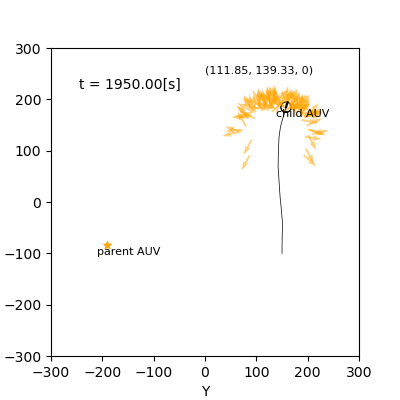

In [11]:
time_interval = 0.1
world = World(1950, time_interval, debug = False)

m = Map()
data1 = [[0.15,0,700],[1.0, -3.6 * math.pi / 180, 25],[0.15,0,500],[0, -3.6 * math.pi / 180, 25],[0.15,0,700]]
agent1 = AgentY(0.1,data1)
initial_pose_1 = np.array([-100,-100,0]).T
m.append_object(Landmark(initial_pose_1, agent = agent1))
world.append(m)    

m1 = Map()
initial_pose_2 = np.array([-100,-50,0]).T
initial_pose_3 = np.array([-100,150,0]).T
accelerate_rate = 2
distance_mintomax = [250,300]
regr_r_slope = [0.3,0.5]
switch = Switch.THROUGH
estimator2 = Mcl(time_interval,m,initial_pose_2,100,switch, accelerate_rate,distance_mintomax, regr_r_slope)
estimator3 = Mcl(time_interval, m,initial_pose_3,100,switch, accelerate_rate,distance_mintomax, regr_r_slope)
c= EstimationAgent(time_interval,0.15,0,switch,accelerate_rate,distance_mintomax, regr_r_slope, estimator3)
# b = EstimationAgent(time_interval,2,0,accelerate_switch, accelerate_rate,distance_minimum, distance_maximum, estimator2)
# r_2 = Robot(initial_pose_2 , sensor = Camera(m),agent = b, color = "blue")
r_1 = Robot(initial_pose_3,sensor = Camera(m), agent = c)
# m1.append_object(r_2)
m1.append_object(r_1)
world.append(m1)
world.draw()

<IPython.core.display.Javascript object>


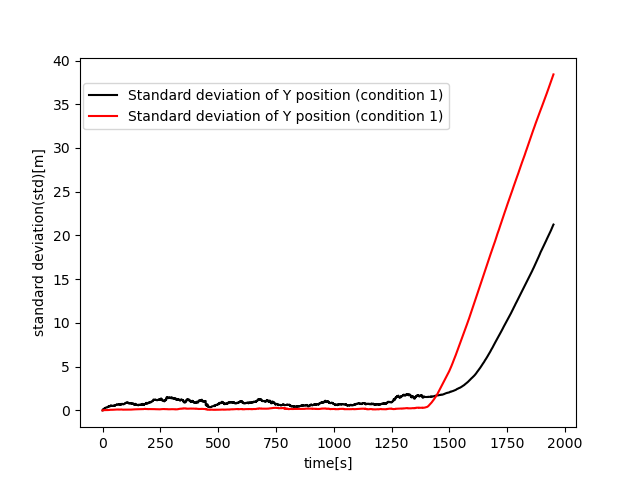

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_xlabel("time[s]")
t = np.zeros(19502)
dt = 0.1
t[0] = 0
for i in range(1,19502):
    t[i] =t[i-1] + dt
    
# ax.set_ylim([0.0,30])
# ax.set_xlim([0.0,1300])
ax.set_ylabel("standard deviation(std)[m]")
plt.plot(t,estimator3.sigma_xs,color = "k",label = "Standard deviation of Y position (condition 1)")
plt.plot(t,estimator3.sigma_ys, color = "r", label = "Standard deviation of Y position (condition 1)")
# ax.set_xticklabels(["0", "20", "40", "60", "80", "100", "120"])
fig.legend(loc = "upper left" ,borderaxespad=6)
plt.show()